In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
from radical.entk import Profiler
import radical.analytics as ra
import radical.utils as ru
import radical.pilot as rp

%matplotlib inline

/home/vivek/ves/ve_entk/lib/python2.7/site-packages/radical/utils/atfork/stdlib_fixer.py:63: UserWarning: logging module already imported before fixup.
  warnings.warn('logging module already imported before fixup.')


In [2]:
# Constants
tasks_list = [16,32,64,128,256,512,1024]


In [3]:
# Generate task uids

def get_task_uids(num_tasks):
    
    task_uids = []
    for t in range(num_tasks):
        task_uids.append('radical.entk.task.%04d'%t)

    return task_uids

In [21]:
df = pd.DataFrame(columns=['EnTK core overhead', 'EnTK overhead', 'RP overhead'])

for tasks in tasks_list:

    json_files = glob.glob('./app_sleep/tasks-{0}/*.json'.format(tasks))
    json_file = json_files[0]
    json      = ru.read_json(json_file)
    sid       = os.path.basename(json_file)[:-5]

    session = ra.Session(sid, 'radical.pilot', src='./app_sleep/tasks-{0}/'.format(tasks))
    units = session.filter(etype='unit', inplace=False)

    p = Profiler(src = './app_sleep/tasks-{0}/'.format(tasks))
    
    task_uids = get_task_uids(tasks)
    
    entk_dur = p.duration(task_uids, states=['SCHEDULING', 'DONE'])
    rp_dur = units.duration([rp.UMGR_SCHEDULING_PENDING, rp.DONE])
    exec_dur = units.duration([rp.AGENT_EXECUTING, rp.AGENT_STAGING_OUTPUT_PENDING])
    
    # Time taken in appmanager to rreq function call
    entk_core_1 = p.duration('radical.entk.appmanager.0000', events=['create amgr obj', 'init rreq submission'])
    
    # Time taken to tear down appmanager
    entk_core_2 = p.duration('radical.entk.appmanager.0000', events=['start termination', 'termination done'])
    
    # Time taken to create resource manager obj
    entk_core_3 = p.duration('radical.entk.resource_manager.0000', events = ['create rmgr obj', 'rmgr obj created'])
    
    # Time taken to create and submit resource reservation
    entk_core_4 = p.duration('radical.entk.resource_manager.0000', events = ['creating rreq', 'rreq submitted'])
    
    # Time taken to deallocate resource reservation
    entk_core_5 = p.duration('radical.entk.resource_manager.0000', events = ['canceling resource allocation', 'resource allocation cancelled'])
    
    # Queue
    queue_time = p.duration('radical.entk.resource_manager.0000', events = ['rreq submitted', 'resource active'])
    
    entk_core_dur = entk_core_1 + entk_core_2 + entk_core_3 
    
    entk_only_overhead = entk_dur - rp_dur
    rp_only_overhead = rp_dur - exec_dur
    total_overhead = entk_only_overhead + rp_only_overhead
    
    print 'Tasks: ',tasks
    print 'EnTK duration: ', entk_dur 
    print 'EnTK core duration: ', entk_core_dur
    print 'RP duration: ', rp_dur
    print 'Execution duration: ', exec_dur
    print '---------------------------------------'
    
    df.loc[tasks] = [entk_core_dur, entk_only_overhead, rp_only_overhead]

Tasks:  16
EnTK duration:  8.80269980431
EnTK core duration:  3.53660011292
RP duration:  6.99300003052
Execution duration:  3.35220003128
---------------------------------------
Tasks:  32
EnTK duration:  12.2228000164
EnTK core duration:  11.2231998444
RP duration:  10.0209000111
Execution duration:  6.02220010757
---------------------------------------
Tasks:  64
EnTK duration:  17.8375999928
EnTK core duration:  5.54279971123
RP duration:  13.6448001862
Execution duration:  9.5517001152
---------------------------------------
Tasks:  128
EnTK duration:  22.4965000153
EnTK core duration:  10.8384001255
RP duration:  20.7053999901
Execution duration:  15.9038999081
---------------------------------------
Tasks:  256
EnTK duration:  37.0110001564
EnTK core duration:  7.57170009613
RP duration:  35.8048000336
Execution duration:  30.1489999294
---------------------------------------
Tasks:  512
EnTK duration:  68.6166000366
EnTK core duration:  4.11690044403
RP duration:  65.9463000298

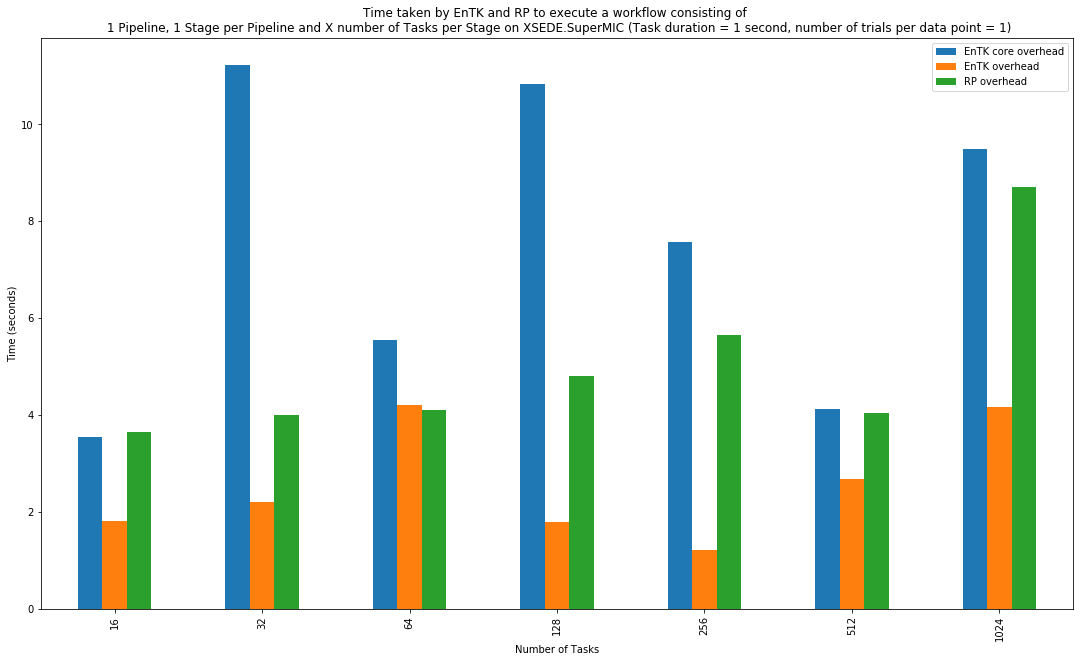

In [22]:
ax = df.plot(kind='bar', title='Time taken by EnTK and RP to execute a workflow consisting of \n 1 Pipeline, 1 Stage per Pipeline and X number of Tasks per Stage on XSEDE.SuperMIC (Task duration = 1 second, number of trials per data point = 1)')
ax.set_xlabel('Number of Tasks')
ax.set_ylabel('Time (seconds)')


fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
fig.savefig('initial_graph.pdf', dpi=100)

In [90]:
duration_exec = units.duration([rp.AGENT_EXECUTING, rp.AGENT_STAGING_OUTPUT_PENDING])

before_exec = units.duration([rp.UMGR_SCHEDULING_PENDING, rp.AGENT_EXECUTING])
after_exec = units.duration([rp.AGENT_STAGING_OUTPUT_PENDING, rp.DONE])

total = units.duration([rp.UMGR_SCHEDULING_PENDING, rp.DONE])
print total

130.013799906


In [40]:
print duration_exec, before_exec, after_exec
total_from_rp = duration_exec + before_exec + after_exec
print total_from_rp

3.35220003128 5.23059988022 0.546700000763
9.12949991226
